# Compression speed

In [7]:
using ZfpCompression, TranscodingStreams, CodecZstd, LinLogQuantization
using NetCDF, BitInformation
using PyPlot, ColorSchemes
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.samples = 3

3

In [4]:
# find file
path = "/network/aopp/chaos/pred/kloewer/esowc/cams/"
filelist = filter(x->endswith(x,"_v3.nc"),readdir(path))
varname = "q"
file = filelist[[occursin(varname,f) for f in filelist]][1]

# load file
ncfile = NetCDF.open(joinpath(path,file))
X = ncfile.vars[varname][:,:,:];

In [5]:
## DEFINE COMPRESSORS
ZstdCompressors = Array{ZstdCompressor,1}(undef,22)

for i in 1:22
    ZstdCompressors[i] = ZstdCompressor(level=i)
    TranscodingStreams.initialize(ZstdCompressors[i])
end

In [10]:
## Compress X with round+Zstd
keepbits = 3
Xr = round(X,3)
Xr8 = copy(reinterpret(UInt8,vec(Xr)));

In [43]:
# cfs = fill(0.0,22)                # compression factors
# speed_comp = fill(0.0,22)         # compression speeds and decompression
# speed_decomp = fill(0.0,22)
ori_size = sizeof(X)*2              # relative to Float64

for i in 10:22   # loop over compression levels
    println(i)
    Xc = transcode(ZstdCompressors[i],Xr8)
    
    # # check whether compression is indeed reversible
    # Xuc = transcode(ZstdDecompressor,Xc)
    # @assert Xuc == Xr8     
    
    cfs[i] = ori_size/sizeof(Xc)
    speed_comp[i] = minimum((@benchmark Xc = transcode(ZstdCompressors[$i],Xr8)).times)/1e9
    speed_decomp[i] = minimum((@benchmark Xuc = transcode(ZstdDecompressor,$Xc)).times)/1e9
end

10
11
12
13
14
15
16
17
18
19
20
21
22


In [39]:
speed_comp

22-element Vector{Float64}:
  0.336281632
  0.32122331
  0.335841428
  0.339031585
  0.601185862
  0.721221688
  1.185135015
  1.354563997
  1.787839811
  1.815049624
  1.798064324
  2.618867085
 10.258235603
 10.55898866
 17.435386595
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [141]:
## Compress with Zfp (+log-preprocessing)
precision = 11
Xzfp = zfp_compress(log.(X);precision)
speed_comp_zfp = minimum((@benchmark Xzfp = zfp_compress(log.(X);precision)).times)/1e9
cfs_zfp = sizeof(X)*2/sizeof(Xzfp)
speed_decomp_zfp = minimum((@benchmark zfp_decompress(Xzfp)).times)/1e9

0.350346616

In [138]:
# Median absolute/relative error from zfp
precision = 11
Xzfp = zfp_compress(log.(X);precision)
Xd = exp.(zfp_decompress(Xzfp))
absX = abs.(X .- Xd)
maez = median(vec(absX))
mrez = median(vec(absX./X))

# and from rounding to keepbits
absX = abs.(X .- Xr)
maer = median(vec(absX))
mrer = median(vec(absX./X))
sizeof(X)*2/sizeof(Xzfp)

71.11999836294946

In [139]:
(maez,maer)

(1.2574492f-7, 1.6578451f-7)

In [140]:
(mrez,mrer)

(0.01468474f0, 0.022351297f0)

In [14]:
## Compress with LinQuant24
Xlin24 = LinQuant16Array(X)
Xlog16 = LogQuant16Array(X)

speed_comp_lin24 = (@benchmark Xlin24 = LinQuant16Array(X)).times[1]/1e9       # use 16 as UInt24 is slow
speed_comp_log16 = (@benchmark Xlog16 = LogQuant16Array(X)).times[1]/1e9

speed_decomp_lin24 = (@benchmark Array{Float32}(Xlin24)).times[1]/1e9
speed_decomp_log16 = (@benchmark Array{Float32}(Xlog16)).times[1]/1e9

0.822890027

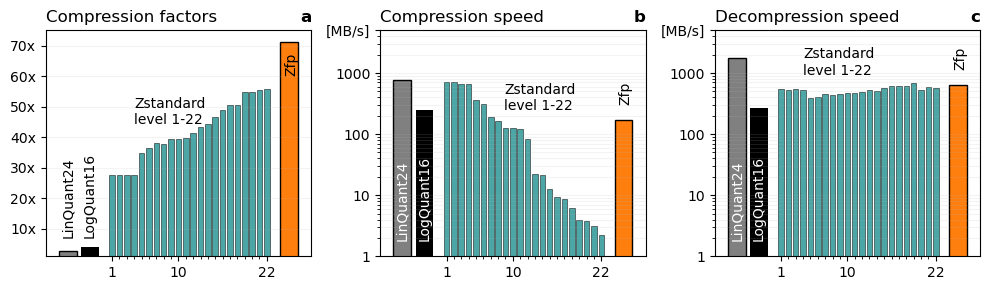

In [142]:
## Plotting
ioff()
fig,(ax1,ax2,ax3) = subplots(1,3,sharex=true,figsize=(10,3))

# ax1.grid(axis="y")
# ax1.set_axisbelow(true)

zstd_x = 3 .+ Array(0:21)/3.0
alfa = 0.7
ori_size = sizeof(X)/1000^2  # in MB

ax1.bar(1,64/24,color="grey",edgecolor="k")
ax1.bar(2,4,color="k")
ax1.bar(zstd_x,cfs,alpha=alfa,color="teal",width=0.25,edgecolor="k",lw=0.5)
ax1.bar(11,cfs_zfp,color="C1",edgecolor="k")

# speed in MB/s
ax2.bar(1,ori_size/speed_comp_lin24,color="grey",edgecolor="k")
ax2.bar(2,ori_size/speed_comp_log16,color="k")
ax2.bar(zstd_x,ori_size./speed_comp,alpha=alfa,color="teal",width=0.25,edgecolor="k",lw=0.5)
ax2.bar(11,ori_size/speed_comp_zfp,color="C1",edgecolor="k")

ax3.bar(1,ori_size/speed_decomp_lin24,color="grey",edgecolor="k")
ax3.bar(2,ori_size/speed_decomp_log16,color="k")
ax3.bar(zstd_x,ori_size./speed_decomp,alpha=alfa,color="teal",width=0.25,edgecolor="k",lw=0.5)
ax3.bar(11,ori_size/speed_decomp_zfp,color="C1",edgecolor="k")

ax2.set_yscale("log")
ax3.set_yscale("log")

ymax = 75
ax1.set_ylim(1,ymax)
ax2.set_ylim(1,5000)
ax3.set_ylim(1,5000)
ax1.set_xlim(0,12)

ax1.set_xticks(zstd_x[[1,10,22]])
ax1.set_xticks(zstd_x[2:end-1],minor=true)
ax1.set_xticklabels([1,10,22])

ax1.text(1,8,"LinQuant24",rotation=90,ha="center")
ax1.text(2,8,"LogQuant16",rotation=90,ha="center")
ax1.text(11.1,cfs_zfp-10,"Zfp",rotation=90,ha="center")
ax1.text(4,cfs[10]+5,"Zstandard\nlevel 1-22")

ax2.text(1,2,"LinQuant24",rotation=90,ha="center",color="w")
ax2.text(2,2,"LogQuant16",rotation=90,ha="center",color="w")
ax2.text(11.1,ori_size/speed_comp_zfp*2,"Zfp",rotation=90,ha="center")
ax2.text(5.6,ori_size/speed_comp[10]*2,"Zstandard\nlevel 1-22")

ax3.text(1,2,"LinQuant24",rotation=90,ha="center",color="w")
ax3.text(2,2,"LogQuant16",rotation=90,ha="center",color="w")
ax3.text(11.1,ori_size/speed_decomp_zfp*2,"Zfp",rotation=90,ha="center")
ax3.text(4,ori_size/speed_decomp[10]*2,"Zstandard\nlevel 1-22")

ytiks = 10:10:ymax
ax1.set_yticks(ytiks)
ax1.set_yticklabels(["$(i)x" for i in ytiks])

ax2.set_yticks([1,10,100,1000,5000])
ax2.set_yticklabels([1,10,100,1000,"[MB/s]"])
ax3.set_yticks([1,10,100,1000,5000])
ax3.set_yticklabels([1,10,100,1000,"[MB/s]"])

# ax2.set_ylabel("MB/s")
# ax3.set_ylabel("MB/s")

ax1.set_title("Compression factors",loc="left")
ax2.set_title("Compression speed",loc="left")
ax3.set_title("Decompression speed",loc="left")

ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax3.set_title("c",loc="right",fontweight="bold")

for ax in [ax1,ax2,ax3]
    ax.grid(alpha=.15,zorder=-10,which="both",axis="y")
end

tight_layout()
# savefig("/Users/milan/git/Elefridge.jl/plots/level_speed_o3.png",dpi=200)